<a href="https://www.kaggle.com/code/amitpant7/pruning-effficientnet-v2-s-on-cifar10?scriptVersionId=135878610" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset
cudnn.benchmark = True
import pandas as pd
plt.ion()   # interactive mode
from tqdm import tqdm

import plotly.express as px

!pip install torch-summary
from torchsummary import summary
import os
import shutil
import random
import json

# Steps
1. Retrain the efficient net model on CIFA-10 Dataset, evaluate it's performance.
2. Write code to calculate the sparsity of CNN layers of model.
3. Iteratively prune the networks.
    -Prune x% and then evaluate model.
    - Retrain model for n epochs.
    -Evaluate
    -Prune x-y % and repeat.

Remove ***%%script echo*** block to run it, I included it so that i don't mess up the code while doing the pruning by runing some block and change everything.

I will be only pruning CNN parameters.

In [2]:
#All the necessary code to load and configure the dataset 
batch_size = 64
path = '/kaggle/input/cifar10-python'
data_dir = '/kaggle/input/tiny-imagenet-reorganized/tiny-imagenet-200'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


trainset = torchvision.datasets.CIFAR10(root=path, 
                                        train=True, download=False, 
                                        transform=data_transforms['train'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root=path, 
                                        train=False, download=False, 
                                        transform=data_transforms['test'])

                                     
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



#Making things easy, so storing it in a dictionary 
dataset_size = [len(trainset), len(testset)]
dataloaders= {
    "train": trainloader,
    "val": testloader
}
dataset_sizes = {
    "train": dataset_size[0],
    "val": dataset_size[1]
}

class_names = trainset.classes

In [18]:
# %%script echo  #exclude block from running
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) #transposing to h,w,c
    mean = np.array([0.485, 0.456, 0.406])  
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean    #back to original
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,10))
    plt.imshow(inp)
    plt.title('Sample Images from CIFAR-10 Dataset')
    if title is not None:
        plt.title(title)
    plt.savefig('CIFAR10')
    plt.pause(0.001)  # pause a bit so that plots are updated

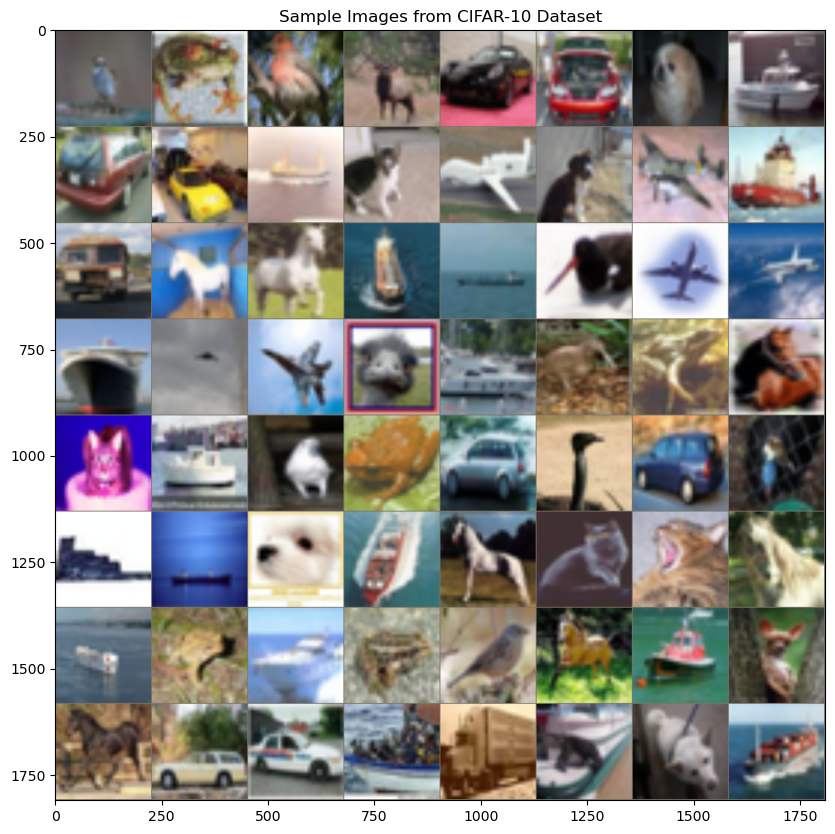

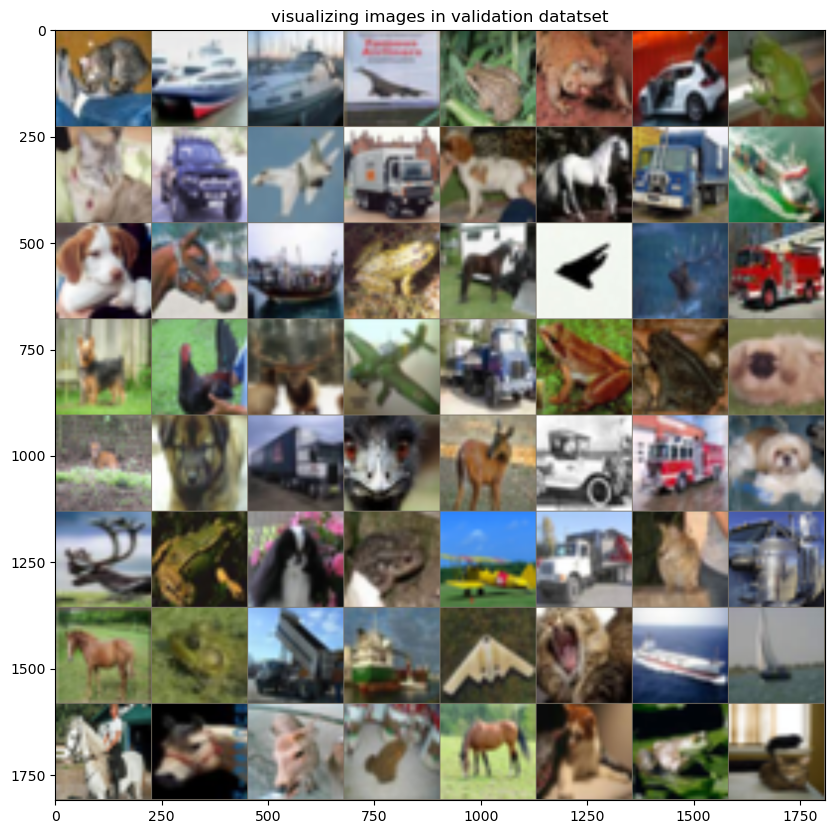

In [19]:

#visualizing trian dataset
# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

#visualizing images in validation datatset
images,labels = next(iter(testloader))
out = torchvision.utils.make_grid(images)
imshow(out, title= 'visualizing images in validation datatset')

In [3]:

#Function for training the model, forware prop and backward prop 
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #storing epoch data
    epoch_data =     {
        'epoch': [],
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': [] }
    }
    
    # Create a temporary directory in Kaggle's temp directory
    tempdir = '/kaggle/working/temp'
    os.makedirs(tempdir, exist_ok=True)
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        epoch_data['epoch'].append(epoch+1)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            

            for inputs, labels in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_data[phase]['loss'].append(epoch_loss)
            epoch_data[phase]['acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    # Clean up the temporary directory
    shutil.rmtree(tempdir)

    return model, epoch_data


#Evaluating the model performance on the test set
def evaluate_model(model, criterion = nn.CrossEntropyLoss() , dataloader = testloader ):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    eval_loss = running_loss / len(dataloader.dataset)
    eval_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Evaluation Loss: {eval_loss:.4f} Acc: {eval_acc:.4f}')

    return eval_loss, eval_acc


#Code to visualize the predictions of model 

def visualize_model(model, num_images=3):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Reframing the Efficient net V2 (small) for 10 classes

In [4]:
%%script echo  #exclude block from running temp
#Model Definations 
model_ft = models.efficientnet_v2_s(weights='IMAGENET1K_V1') 

# for param in model_ft.parameters():
#     param.requires_grad = False

num_ftrs = model_ft.classifier[1].in_features #get the total number of features input to the FC layer.
# Here the size of each output sample is set to 2.

# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.classifier[1] = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#exclude block from running temp


This was done, model was trained for 20 epochs and I was able to rich accuracy of 97.92%. The highest SOTA results on CIFAR-10 using efficientnet-v2(small) was 98.7.

In [44]:
%%script echo
#Training the model 
model_ft, epoch_data = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

In [45]:
%%script echo
#Saving the model to working directory 
path = '/kaggle/working/'
best_model = os.path.join(path, 'efficientnet.pt')
torch.save(model_ft.state_dict(), best_model)

In [46]:
%%script echo
#Saving the train data
import json
n = random.randint(4, 75)
filename = f'plot_data{n}.json'
with open(filename, 'w') as file:
    json.dump(plot_data, file)

In [47]:
%%script echo
path = '/kaggle/working/'
best_model = os.path.join(path, 'best_model_9791.pt')
torch.save(model, best_model)

In [48]:
%%script echo
#save the data for future plot
filename = 'epoch_data3.json'
with open(filename, 'w') as file:
    json.dump(epochs, file)

In [5]:
#Plots the Model loss and accuracy graphs
def plot_model_train(epoch_data, title = ' '):
    epoch_data= convert_numpy(epoch_data)
    epochs = epoch_data['epoch']
    train_loss = epoch_data['train']['loss']
    val_loss = epoch_data['val']['loss']
    train_acc = epoch_data['train']['acc']
    val_acc = epoch_data['val']['acc']

    # Plotting the training and validation loss
    plt.figure(1)
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='s')
    plt.xlabel('Epoch', color='black')
    plt.ylabel('Loss', color='black')
    plt.title('Training and validation loss'+title, color='black')
    plt.legend(loc='upper right', facecolor='white', framealpha=1)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.tick_params(axis='x', colors='black')
    plt.tick_params(axis='y', colors='black')
    plt.savefig('plot2.png')
    # Plotting the training and validation accuracy
    plt.figure(2)
    plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='^')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='--', marker='d')
    plt.xlabel('Epoch', color='black')
    plt.ylabel('Accuracy', color='black')
    plt.title('Training and validation accuracy'+title, color='black')
    plt.legend(loc='lower right', facecolor='white', framealpha=1)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.tick_params(axis='x', colors='black')
    plt.tick_params(axis='y', colors='black')
    
    n = random.randint(0,100)
    plt.savefig(f'plot{n}.png')

    plt.show()
    

#the epoch data is stored as tensor need to convert to numpy array
#accuracy is stored as tensor so -> to array
def convert_numpy(epoch_data, correction =None):
    if correction is None:
        epochs = epoch_data['epoch']
    else:
        epochs = correction
    train_loss = epoch_data['train']['loss']
    val_loss = epoch_data['val']['loss']
    train_acc = epoch_data['train']['acc']
    val_acc = epoch_data['val']['acc']
    
    
    train_acc = list([x.to('cpu').detach().numpy().astype('float32') for x in train_acc])
    val_acc = list([x.to('cpu').detach().numpy().astype('float32') for x in val_acc])
    train_acc = np.ravel(train_acc).tolist()
    val_acc = np.ravel(val_acc).tolist()
    
    epoch_dict =     {
        'epoch': epochs,
        'train': {'loss': train_loss, 'acc': train_acc},
        'val': {'loss': val_loss, 'acc': val_acc}
    }
    
    return epoch_dict


In [50]:
%%script echo
#Not need for now
#serialy combining all json files:
# List of JSON file paths 
file_paths = ['/kaggle/working/epoch_data.json', '/kaggle/working/epoch_data2.json', 
              
              '/kaggle/working/epoch_data3.json']

plot_data = {
        'epoch': [],
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': []}
    }


# Read and merge JSON data from each file
for file_path in file_paths:
    with open(file_path, 'r') as file:
        epoch_data = json.load(file)
        epochs = epoch_data['epoch']
        train_loss = epoch_data['train']['loss']
        val_loss = epoch_data['val']['loss']
        train_acc = epoch_data['train']['acc']
        val_acc = epoch_data['val']['acc']
        
        plot_data['epoch']+= epochs
        plot_data['train']['loss']+=train_loss
        plot_data['val']['loss']+=val_loss
        plot_data['train']['acc']+=train_acc
        plot_data['val']['acc']+=val_acc
        


In [51]:
%%script echo
with open('plot_data.json', 'w') as file:
    json.dump(plot_data,file)

In [52]:
%%script echo
plot_model_train(plot_data)


# Starting pruning


In [53]:
#loading saved model from kaggle working direct

model= torch.load('/kaggle/working/best_model_9791.pt', map_location=  torch.device("cpu"))
# model = model.to(device)


In [30]:
#To load model in gpu
model= torch.load('/kaggle/working/best_model_9791.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


In [32]:
# Parameter distribution before pruning.
visualize_par(model, title='Fig: Parameter distribution in EfficientNet-V2 before pruning')

,Block,No. of parameters,FusedMBConv,MBConv,"FusedMBconv, MBConv"
0,1,648,0,0,"0,0"
1,2,10368,2,0,"2,0"
2,3,301824,4,0,"4,0"
3,4,586752,4,0,"4,0"
4,5,901888,0,6,"0,6"
5,6,3418368,0,9,"0,9"
6,7,14440896,0,15,"0,15"
7,8,327680,0,0,"0,0"


In [55]:
# # weight visualization of model
# import plotly.express as px
# import matplotlib.cm as cm
# plt.figure(figsize=(10, 5))
# plt.title("Weights Visualization")
# layer_names = []


# layer_names = []
# count =0
# shape_data=[]
# for name, param in model.named_parameters():
#     weights = param.data
#     if int(weights.dim()) == 4:
#         if count%10 ==0:
#             weights = weights.view(weights.shape[0], -1)  # 1D
#             layer_names.append(name)
# # #           plt.imshow(weights, cmap='seismic', vmin=np.nanmin(weights), vmax=np.nanmax(weights))
# #             plt.colorbar()
# #             plt.title(name)
# #             plt.axis('off')
# #             plt.show()
#             px.strip(weights, x='weight')
#         count+=1




# Parameter Calculation

In [20]:
#percentage of zero calculation in conv layer only

#Calculate sparsity, works on the mask too but not layer wise
def cal_sparsity(model):
    z=0
    para= 0
    for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules()):
        para+= module.weight.numel() 
        z+= torch.sum(module.weight==0)
    sparsity = z/para
    print(f'sparisty: {sparsity*100}% \nZero_Wt: {z}\nTotal Params: {para}')
    return sparsity, z, para


#Calculates the block wise Sparsity but works only after making pruning permanent
def per_zero(model):
    total_sum=0
    no_of_zeros=0
    for name, param in model.named_parameters():
        weights = param.data
        if int(weights.dim()) == 4:
            weights = weights.view(-1)  # 1D
            total_sum += weights.shape[0]
            no_of_zeros += torch.sum(weights == 0).item()
    sparsity = (no_of_zeros/total_sum)*100
#     print(f'Sparsit:{sparsity}\n Total Params: {total_sum} \n Zero Params: {no_of_zeros}' )
    return sparsity, total_sum, no_of_zeros 


#weight distribution before the pruning, returns the distriubtion of weights in different blocks
#efficientnet is abstractly divided in 8 blocks
def weight_distribution(model):
    i = 1
    MB_conv=[]
    FMB_con=[]
    data = []
    for module in model.features:
        _, total_par, zero = per_zero(module)
        a=0
        b=0
        temp=[]
        for md in filter(lambda m: type(m) == torchvision.models.efficientnet.FusedMBConv, module.modules()):
            a+=1
            
        for md in filter(lambda m: type(m) == torchvision.models.efficientnet.MBConv, module.modules()):
            b+=1

        name = f'Block No. {i}'
        data.append([i, total_par-zero, a,b ])
        i+=1
    data= np.array(data)
    return data


#Visualizing the Parameters
def visualize_par(model, title ="Fig: Visualization of prameters in different Blocks"):
    data = weight_distribution(model)
    df = pd.DataFrame(data, columns=["Block", "No. of parameters", "FusedMBConv", "MBConv"])
    df["FusedMBconv, MBConv"] = df["FusedMBConv"].astype(str)+','+df["MBConv"].astype(str)


    fig = px.bar(df, x="Block",
                 title=title,
                 y ="No. of parameters", color = 'FusedMBconv, MBConv')

    fig.update_layout(yaxis_type='log')
    fig.show()
    return df

In [57]:
%%script echo
data = weight_distribution(model)
df = visualize_par(data)
print(df)


# Starting Pruning

In [9]:
#all import stat
import torch.nn.utils.prune as prune


In [10]:
#all funcs

#Pruning process
def pruning(model, amt=0.4, method= prune.L1Unstructured):
    parameters_to_prune = [
        (module, "weight") for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules())
    ]


    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=method,
        amount=amt,
    )
    
    print('Completed Pruning.........')
    return model

#Removes the mask and applies pruning permanently 
def remove_mask(model):
    for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules()):
        prune.remove(module, 'weight')
    
    

#retraining for n epochs
def retrain(model, n):
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model, epoch_data = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=n)
    
    return model, epoch_data
    

In [60]:
#Randomly pruning 40% of weights 
model = pruning(model)
loss, acc = evaluate_model(model)
print(loss, acc)

s, z , total = cal_sparsity(model)
print(s, z , total )

Completed Pruning.........
Evaluation Loss: 0.2559 Acc: 0.9299
0.25592687972784045 tensor(0.9299, device='cuda:0', dtype=torch.float64)
sparisty: 40.0% 
Zero_Wt: 7995370
Total Params: 19988424
tensor(0.4000, device='cuda:0') tensor(7995370, device='cuda:0') 19988424


I retrained the model after pruning it 40%, the accuracy intialy dropped to 92.29%, on retraining, the accuracy increased to 97.52.

#The original model trained on CIFAR-10 for 20 epochs had** 97.92% accuracy.**

In [ ]:
#retraining for 3 epochs
model, epochs = retrain(model, 3)


In [15]:
#Loading the 40% sparse model and evaluating it's performance.
model = torch.load('/kaggle/working/model_40per_sparse.pt')
loss, acc = evaluate_model(model)
s, z , total = cal_sparsity(model)

Evaluation Loss: 0.0868 Acc: 0.9753
sparisty: 40.0% 
Zero_Wt: 7995370
Total Params: 19988424


# Iteravile pruning: Pruning 30% more parms from the sparse model


In [16]:
#Iteratively pruning 
#Randomly pruning 40% of weights 
model = pruning(model, amt = 0.3)
loss, acc = evaluate_model(model)
s, z , total = cal_sparsity(model)


Completed Pruning.........
Evaluation Loss: 0.6323 Acc: 0.8037
sparisty: 58.0% 
Zero_Wt: 11593286
Total Params: 19988424


In [17]:
#retrain for next 5 epochs 
model, epochs = retrain(model, 5)

Epoch 1/5
----------


train Loss: 0.0570 Acc: 0.9814


val Loss: 0.1028 Acc: 0.9700

Epoch 2/5
----------


train Loss: 0.0374 Acc: 0.9877


val Loss: 0.0987 Acc: 0.9721

Epoch 3/5
----------


train Loss: 0.0272 Acc: 0.9916


val Loss: 0.0968 Acc: 0.9720

Epoch 4/5
----------


train Loss: 0.0226 Acc: 0.9927


val Loss: 0.0936 Acc: 0.9735

Epoch 5/5
----------


train Loss: 0.0213 Acc: 0.9935


val Loss: 0.0944 Acc: 0.9741

Training complete in 28m 51s
Best val Acc: 0.974100


In [18]:
torch.save(model, '58%_sparse_model.pt')

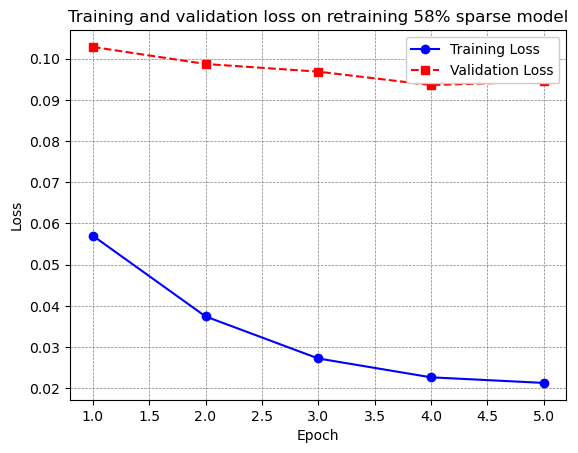

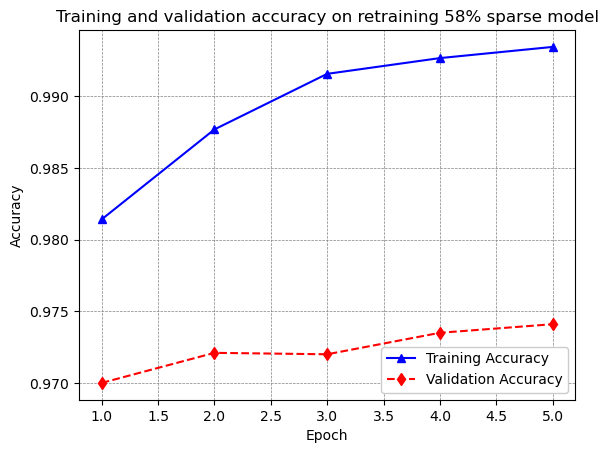

In [28]:
plot_model_train(epochs, title= ' on retraining 58% sparse model')

In [20]:
loss, acc = evaluate_model(model)
s, z , total = cal_sparsity(model)

Evaluation Loss: 0.0944 Acc: 0.9741
sparisty: 58.0% 
Zero_Wt: 11593286
Total Params: 19988424


# Pruning 30% more weights

In [23]:
model = pruning(model, amt = 0.3)
loss, acc = evaluate_model(model)
s, z , total = cal_sparsity(model)

Completed Pruning.........
Evaluation Loss: 1.4565 Acc: 0.6354
sparisty: 70.5999984741211% 
Zero_Wt: 14111827
Total Params: 19988424


**** The accuracy decreased to 70%, re-training it for 10 epochs.****

Epoch 1/10
----------


train Loss: 0.0620 Acc: 0.9793


val Loss: 0.1064 Acc: 0.9707

Epoch 2/10
----------


train Loss: 0.0397 Acc: 0.9872


val Loss: 0.1060 Acc: 0.9726

Epoch 3/10
----------


train Loss: 0.0333 Acc: 0.9891


val Loss: 0.1046 Acc: 0.9734

Epoch 4/10
----------


train Loss: 0.0289 Acc: 0.9908


val Loss: 0.1037 Acc: 0.9731

Epoch 5/10
----------


train Loss: 0.0245 Acc: 0.9919


val Loss: 0.1039 Acc: 0.9740

Epoch 6/10
----------


train Loss: 0.0211 Acc: 0.9934


val Loss: 0.1052 Acc: 0.9743

Epoch 7/10
----------


train Loss: 0.0205 Acc: 0.9938


val Loss: 0.1055 Acc: 0.9729

Epoch 8/10
----------


train Loss: 0.0164 Acc: 0.9950


val Loss: 0.1026 Acc: 0.9750

Epoch 9/10
----------


train Loss: 0.0159 Acc: 0.9949


val Loss: 0.1022 Acc: 0.9742

Epoch 10/10
----------


train Loss: 0.0157 Acc: 0.9951


val Loss: 0.1030 Acc: 0.9742

Training complete in 57m 35s
Best val Acc: 0.975000


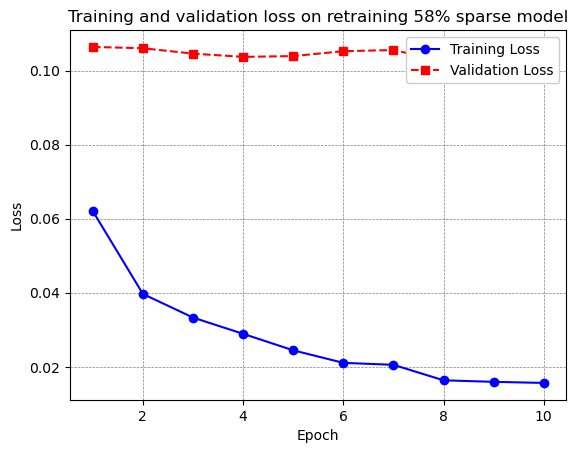

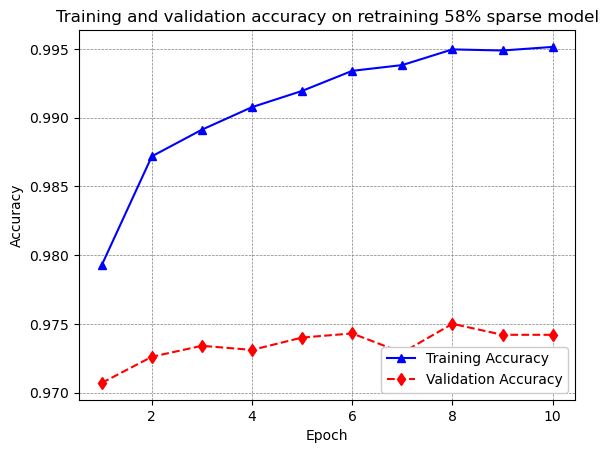

In [29]:
model, epochs = retrain(model, 10)
torch.save(model, '70%_sparse_model.pt')
plot_model_train(epochs, title= ' on retraining 70% sparse model')

label wrong in above plot, it's plot of retraining on 70% sparse 

In [30]:
loss, acc = evaluate_model(model)
s, z , total = cal_sparsity(model)

Evaluation Loss: 0.1026 Acc: 0.9750
sparisty: 70.5999984741211% 
Zero_Wt: 14111827
Total Params: 19988424


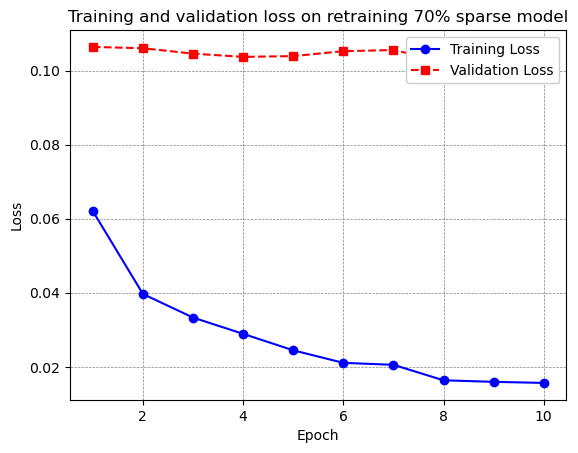

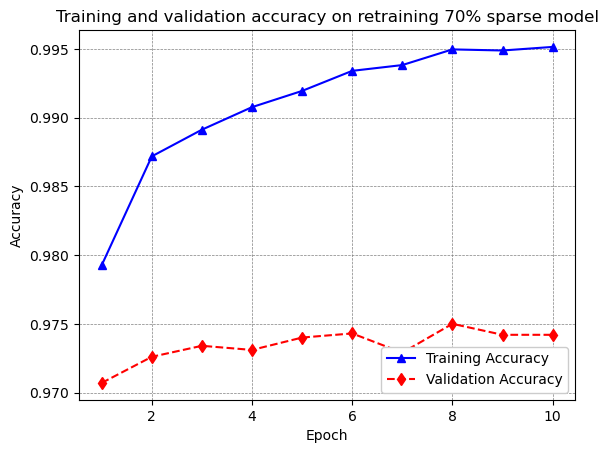

In [31]:
plot_model_train(epochs, title= ' on retraining 70% sparse model')

Let's try pruning the model again and see the results

In [32]:
model = pruning(model, amt=0.2)

Completed Pruning.........


In [35]:
evaluate_model(model)
cal_sparsity(model)

Evaluation Loss: 1.4394 Acc: 0.5281
sparisty: 76.47999572753906% 
Zero_Wt: 15287146
Total Params: 19988424


(tensor(0.7648, device='cuda:0'), tensor(15287146, device='cuda:0'), 19988424)

Let's try retaining and see if the can recover accuracy or not

In [36]:
model, epochs = retrain(model, 5)


Epoch 1/5
----------


train Loss: 0.0432 Acc: 0.9859


val Loss: 0.1083 Acc: 0.9707

Epoch 2/5
----------


train Loss: 0.0294 Acc: 0.9903


val Loss: 0.1061 Acc: 0.9730

Epoch 3/5
----------


train Loss: 0.0245 Acc: 0.9917


val Loss: 0.1042 Acc: 0.9740

Epoch 4/5
----------


train Loss: 0.0211 Acc: 0.9933


val Loss: 0.1055 Acc: 0.9732

Epoch 5/5
----------


train Loss: 0.0195 Acc: 0.9934


val Loss: 0.1026 Acc: 0.9748

Training complete in 28m 43s
Best val Acc: 0.974800


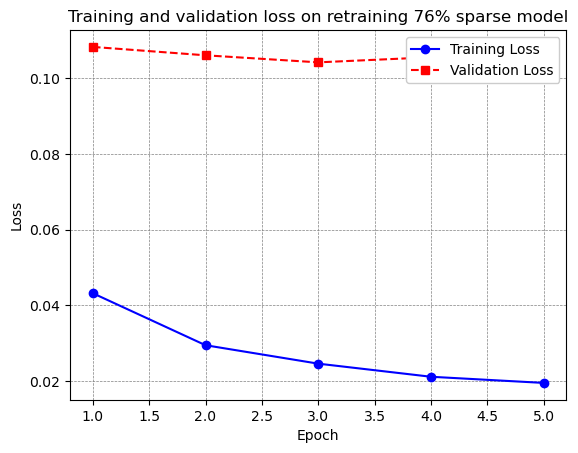

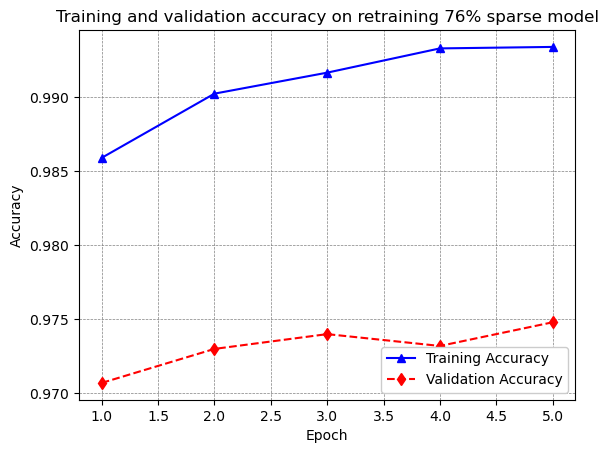

In [37]:
torch.save(model, '76%_sparse_model.pt')
plot_model_train(epochs, title= ' on retraining 76% sparse model')

Let's try pruning more 

In [6]:
model = torch.load('/kaggle/working/76%_sparse_model.pt')

We try pruning 20% of remaining weight.

In [ ]:
model = pruning(model, amt=0.2)

In [13]:
evaluate_model(model)
cal_sparsity(model)

Evaluation Loss: 1.3994 Acc: 0.6007
sparisty: 81.18399047851562% 
Zero_Wt: 16227402
Total Params: 19988424


(tensor(0.8118, device='cuda:0'), tensor(16227402, device='cuda:0'), 19988424)

Let's try retraining it 

In [14]:
model, epochs = retrain(model, 5)


Epoch 1/5
----------


train Loss: 0.0629 Acc: 0.9795


val Loss: 0.1065 Acc: 0.9698

Epoch 2/5
----------


train Loss: 0.0403 Acc: 0.9867


val Loss: 0.1036 Acc: 0.9713

Epoch 3/5
----------


train Loss: 0.0339 Acc: 0.9890


val Loss: 0.1081 Acc: 0.9725

Epoch 4/5
----------


train Loss: 0.0299 Acc: 0.9902


val Loss: 0.1053 Acc: 0.9733

Epoch 5/5
----------


train Loss: 0.0255 Acc: 0.9918


val Loss: 0.1028 Acc: 0.9731

Training complete in 29m 16s
Best val Acc: 0.973300


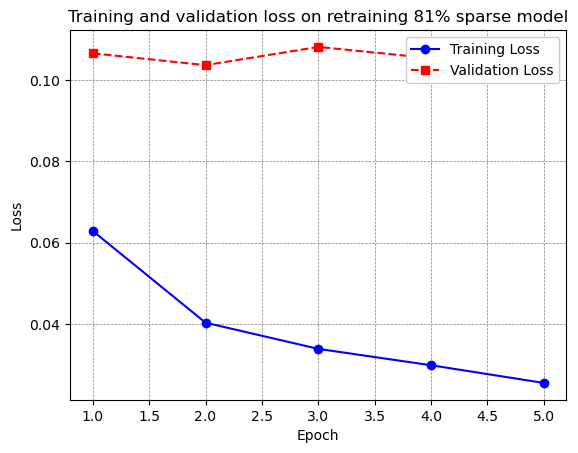

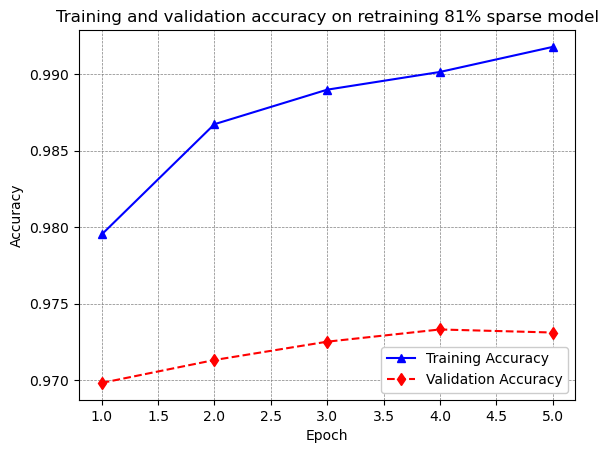

In [15]:
plot_model_train(epochs, title= ' on retraining 81% sparse model')

In [16]:
#Need to try few more epochs:

model, epochs2 = retrain(model, 5)



Epoch 1/5
----------


train Loss: 0.0256 Acc: 0.9919


val Loss: 0.1060 Acc: 0.9734

Epoch 2/5
----------


train Loss: 0.0224 Acc: 0.9927


val Loss: 0.1074 Acc: 0.9733

Epoch 3/5
----------


train Loss: 0.0208 Acc: 0.9937


val Loss: 0.1048 Acc: 0.9759

Epoch 4/5
----------


train Loss: 0.0197 Acc: 0.9938


val Loss: 0.1110 Acc: 0.9745

Epoch 5/5
----------


train Loss: 0.0161 Acc: 0.9950


val Loss: 0.1107 Acc: 0.9756

Training complete in 29m 9s
Best val Acc: 0.975900


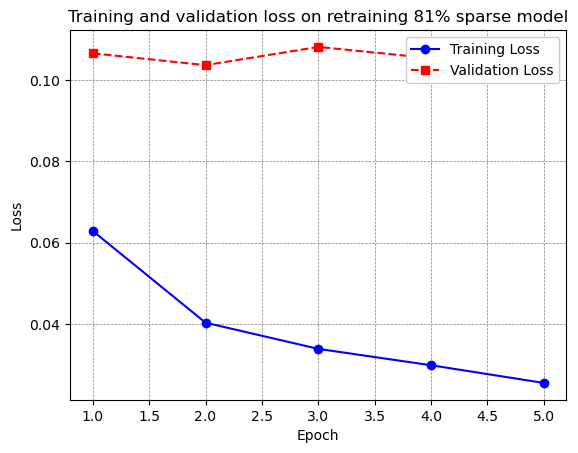

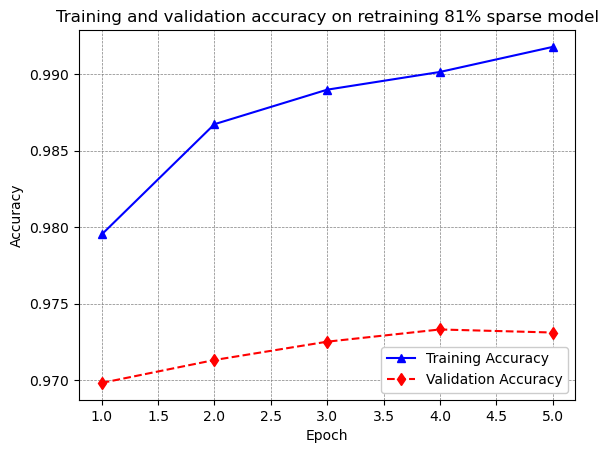

In [17]:
torch.save(model, '81%_sparse_model.pt')
plot_model_train(epochs, title= ' on retraining 81% sparse model')

**Let's visualize the model, for that I will have to remove the mask, i.e make the pruning permannet.**

In [ ]:
#remove mask
remove_mask(model)


In [35]:
#Parameter visualization
visualize_par(model, title ="Fig: Prameter distribution after pruning 81% of the Network ")

,Block,No. of parameters,FusedMBConv,MBConv,"FusedMBconv, MBConv"
0,1,511,0,0,"0,0"
1,2,5667,2,0,"2,0"
2,3,106139,4,0,"4,0"
3,4,157641,4,0,"4,0"
4,5,260844,0,6,"0,6"
5,6,739906,0,9,"0,9"
6,7,2369347,0,15,"0,15"
7,8,120967,0,0,"0,0"


In [25]:
torch.save(model, '81%_pruned_unmasked_model.pt')

In [ ]:
%%script echo
#data unstructured

accu_before_pruning : [_, 97.92, 97.53, 97.41,97.50, 97.48,  ]
prune_per:   [0 ,40,30,30,20,20]
total sparsity: [0, 40, 58, 70,76, 80]
Accuracy after pruning: [_ ,92.29, 80.37, 63.54, 52.81, 60,]
retrain epoch:[0, 3, 5, 10, 5, 5, 10]
accuracy after retrain: [_, 97.53, 97.41,97.50, 97.48, 97.6]
    